# Feed forward NN using augmented data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.contrib import rnn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Masking, Embedding

C:\Users\Sam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\Sam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\Sam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\Sam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be unders

In [2]:
gldata = pd.read_csv('C:/Users/Sam/Documents/ML4EnvEng/Project_Data/GLDData/data/clean/df_aug.csv')
gldata.head()

Unnamed: 0  clouds  hur_ice  mi_ice  land_temp  lake_temp  wind  lake_mm  \
0           0   71.83    31.27   26.17      -5.97      -4.08  7.73     42.9   
1           1   73.45    68.11   36.97      -7.86      -6.04  7.07     33.9   
2           2   75.43    57.04   22.22       3.07       3.36  5.44     64.4   
3           3   68.06     6.88    0.00       5.87       5.80  5.70     70.5   
4           4   69.83     0.00    0.00      10.46      10.07  4.73    120.6   

   land_mm  inflow  chicago  outflow     wse  time_derivative  
0     44.2  2120.0     75.0   5860.0  176.98        39.745553  
1     33.5  1610.0     56.0   5490.0  176.95       103.057722  
2     72.4  1500.0    130.0   5690.0  176.98      -224.917383  
3     69.2  1560.0    128.0   6060.0  177.10       -38.395923  
4    124.9  1560.0    112.0   6260.0  177.20       -28.525448

In [3]:
gldata.shape

(2736, 14)

In [4]:
x = ['clouds','mi_ice','hur_ice','land_temp','lake_temp','wind','lake_mm','land_mm']
y = ['time_derivative']

In [5]:
gl_features = gldata[x].copy()
gl_labels = gldata[y].copy()

In [6]:
fig = px.scatter_matrix(gl_features,dimensions=x)
fig.update_layout(showlegend=False,
                  title_text="Feature Correlation",
                  title_x=0.5, height =800, width = 800)
fig.show()

In [7]:
pca = PCA()
components = pca.fit_transform(gl_features[x])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(components, labels = labels,dimensions = range(6))
fig.update_layout(showlegend=False,
                  title_text="PCA Covariation",
                  title_x=0.5, height =1000, width = 1000)
fig.show()

In [8]:
pca.fit(gl_features)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

In [9]:
pca_features = pd.DataFrame(data = components)
pca_features.columns = ['pca1','pca2','pca3','pca4','pca5','pca6','pca7','pca8']
pca_ = ['pca1','pca2','pca3','pca4','pca5']
features = pca_features[pca_].copy()
features.head()

pca1       pca2       pca3       pca4      pca5
0 -45.183374   0.523932 -11.858207  -1.150424  5.075572
1 -77.476185  20.323216  -1.913670   2.754059 -2.182251
2 -25.447697  33.434108   0.057318  11.133297 -6.994494
3   7.353356  -7.294191 -12.023225  -2.078447 -0.413063
4  71.755660  31.674025  -9.080407   0.709354  0.620171

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, gl_labels, test_size=0.25, random_state=324)
X_train.head()

pca1       pca2       pca3      pca4       pca5
684  -46.949972   9.713264 -15.865749  5.554807  -0.415130
2383  40.514484   0.851180   3.805442  5.113873   4.275066
563  -31.277983 -22.965823 -26.963620 -0.028079   3.134172
1656 -12.415957  65.377209  -4.239998  2.129139  -3.911232
1981 -86.321140  39.576975   4.141392  9.188092  17.179089

In [11]:
x_mean = X_train.mean(axis=0)
x_std = X_train.std(axis=0)
X_train = (X_train - x_mean) / x_std # (train_data - min) / (max-min) 
X_test = (X_test - x_mean) / x_std

X_train.head()

pca1      pca2      pca3      pca4      pca5
684  -1.113137  0.347311 -1.135771  0.930795 -0.076613
2383  0.977582  0.023394  0.279719  0.855965  0.823673
563  -0.738520 -0.847137 -1.934347 -0.016667  0.604677
1656 -0.287648  2.381875 -0.299211  0.349431 -0.747692
1981 -2.054252  1.438854  0.303893  1.547394  3.300608

# Model Definition

In [12]:
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(16, activation=tf.nn.relu,
                       input_shape=(X_train.shape[1],),
                       name='hidden_layer_1',),
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(X_train.shape[1],),
                       name='hidden_layer_2',),
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(X_train.shape[1],),
                       name='hidden_layer_3',),
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(X_train.shape[1],),
                       name='hidden_layer_4',),
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(X_train.shape[1],),
                       name='hidden_layer_5',),
    keras.layers.Dense(1, name='output_layer',)
])


model.compile(loss='mse', optimizer = 'adam', metrics=['mae'])

history = model.fit(X_train,y_train,epochs=1000,validation_split=0.2,verbose=2)

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 1641 samples, validate on 411 samples
Epoch 1/1000
1641/1641 - 0s - loss: 432473.1127 - mean_absolute_error: 226.5668 - val_loss: 554950.1358 - val_mean_absolute_error: 241.3481
Epoch 2/1000
1641/1641 - 0s - loss: 432375.0359 - mean_absolute_error: 226.3102 - val_loss: 554688.4431 - val_mean_absolute_error: 240.9916
Epoch 3/1000
1641/1641 - 0s - loss: 431984.9964 - mean_absolute_error: 224.6351 - val_loss: 553072.8025 - val_mean_absolute_error: 239.1126
Epoch 4/1000
1641/1641 - 0s - loss: 430611.7078 - mean_absolute_error: 223.0535 - val_loss: 550435.3299 - val_mean_absolute_error: 241.0308
Epoch 5/1000
1641/1641 - 0s - loss: 429058.1374 - mean_absolute_error: 227.0208 - val_loss: 554924.1369 - val_mean_absolute_error: 240.3814
Epoch 6/1000
1641/1641 - 0s - loss: 428843.0768 - mean_absolute_error: 225.4651 - val_loss: 545631.7434 - val_mean_absolute_error: 244.

Epoch 57/1000
1641/1641 - 0s - loss: 54157.4100 - mean_absolute_error: 146.5298 - val_loss: 63736.2113 - val_mean_absolute_error: 161.7745
Epoch 58/1000
1641/1641 - 0s - loss: 53099.6316 - mean_absolute_error: 145.9242 - val_loss: 67711.6960 - val_mean_absolute_error: 171.2385
Epoch 59/1000
1641/1641 - 0s - loss: 54276.2118 - mean_absolute_error: 148.5020 - val_loss: 62221.7245 - val_mean_absolute_error: 162.7896
Epoch 60/1000
1641/1641 - 0s - loss: 51428.3342 - mean_absolute_error: 142.6275 - val_loss: 61212.8011 - val_mean_absolute_error: 159.0538
Epoch 61/1000
1641/1641 - 0s - loss: 50938.7132 - mean_absolute_error: 142.3766 - val_loss: 61470.9492 - val_mean_absolute_error: 162.5599
Epoch 62/1000
1641/1641 - 0s - loss: 49377.0622 - mean_absolute_error: 142.2570 - val_loss: 58464.5970 - val_mean_absolute_error: 157.1655
Epoch 63/1000
1641/1641 - 0s - loss: 46988.0983 - mean_absolute_error: 138.4760 - val_loss: 59355.8224 - val_mean_absolute_error: 157.7691
Epoch 64/1000
1641/1641 - 0

Epoch 116/1000
1641/1641 - 0s - loss: 24749.0430 - mean_absolute_error: 108.4118 - val_loss: 33824.4071 - val_mean_absolute_error: 122.3643
Epoch 117/1000
1641/1641 - 0s - loss: 21854.6576 - mean_absolute_error: 100.0368 - val_loss: 38306.9673 - val_mean_absolute_error: 124.8933
Epoch 118/1000
1641/1641 - 0s - loss: 22695.3941 - mean_absolute_error: 102.2836 - val_loss: 34710.9774 - val_mean_absolute_error: 129.9518
Epoch 119/1000
1641/1641 - 0s - loss: 22122.8729 - mean_absolute_error: 100.3353 - val_loss: 33131.6933 - val_mean_absolute_error: 117.2660
Epoch 120/1000
1641/1641 - 0s - loss: 22236.0222 - mean_absolute_error: 102.0035 - val_loss: 31107.8452 - val_mean_absolute_error: 114.5134
Epoch 121/1000
1641/1641 - 0s - loss: 24895.5294 - mean_absolute_error: 105.1090 - val_loss: 33975.0238 - val_mean_absolute_error: 120.1601
Epoch 122/1000
1641/1641 - 0s - loss: 26827.0794 - mean_absolute_error: 112.5977 - val_loss: 33960.0893 - val_mean_absolute_error: 118.8201
Epoch 123/1000
1641/

Epoch 175/1000
1641/1641 - 0s - loss: 19547.6940 - mean_absolute_error: 98.3146 - val_loss: 26319.2570 - val_mean_absolute_error: 104.8234
Epoch 176/1000
1641/1641 - 0s - loss: 15087.6926 - mean_absolute_error: 85.2771 - val_loss: 23465.1167 - val_mean_absolute_error: 104.9018
Epoch 177/1000
1641/1641 - 0s - loss: 16782.5625 - mean_absolute_error: 90.7563 - val_loss: 25690.6805 - val_mean_absolute_error: 105.1714
Epoch 178/1000
1641/1641 - 0s - loss: 12946.4374 - mean_absolute_error: 77.9848 - val_loss: 21971.5133 - val_mean_absolute_error: 91.6118
Epoch 179/1000
1641/1641 - 0s - loss: 13370.8424 - mean_absolute_error: 77.8506 - val_loss: 21918.0198 - val_mean_absolute_error: 98.2662
Epoch 180/1000
1641/1641 - 0s - loss: 12216.1014 - mean_absolute_error: 73.7503 - val_loss: 22186.8776 - val_mean_absolute_error: 97.3807
Epoch 181/1000
1641/1641 - 0s - loss: 12509.3195 - mean_absolute_error: 75.1165 - val_loss: 24842.1785 - val_mean_absolute_error: 101.7436
Epoch 182/1000
1641/1641 - 0s 

Epoch 235/1000
1641/1641 - 0s - loss: 8568.4771 - mean_absolute_error: 61.9260 - val_loss: 20092.9420 - val_mean_absolute_error: 87.6588
Epoch 236/1000
1641/1641 - 0s - loss: 7896.9318 - mean_absolute_error: 58.8790 - val_loss: 16934.1934 - val_mean_absolute_error: 78.7832
Epoch 237/1000
1641/1641 - 0s - loss: 8909.8027 - mean_absolute_error: 62.9711 - val_loss: 20636.7520 - val_mean_absolute_error: 89.5958
Epoch 238/1000
1641/1641 - 0s - loss: 8364.7699 - mean_absolute_error: 60.7814 - val_loss: 16858.3065 - val_mean_absolute_error: 80.8030
Epoch 239/1000
1641/1641 - 0s - loss: 7068.5122 - mean_absolute_error: 54.4069 - val_loss: 16573.0836 - val_mean_absolute_error: 77.8346
Epoch 240/1000
1641/1641 - 0s - loss: 7268.2769 - mean_absolute_error: 57.4980 - val_loss: 16050.8870 - val_mean_absolute_error: 81.3464
Epoch 241/1000
1641/1641 - 0s - loss: 10321.9874 - mean_absolute_error: 68.9985 - val_loss: 17970.0273 - val_mean_absolute_error: 89.5675
Epoch 242/1000
1641/1641 - 0s - loss: 88

Epoch 295/1000
1641/1641 - 0s - loss: 6253.7734 - mean_absolute_error: 51.1903 - val_loss: 13627.3309 - val_mean_absolute_error: 72.3194
Epoch 296/1000
1641/1641 - 0s - loss: 6227.7548 - mean_absolute_error: 53.3609 - val_loss: 15128.3774 - val_mean_absolute_error: 72.9123
Epoch 297/1000
1641/1641 - 0s - loss: 6241.3743 - mean_absolute_error: 53.8411 - val_loss: 13944.8922 - val_mean_absolute_error: 69.6333
Epoch 298/1000
1641/1641 - 0s - loss: 5775.1109 - mean_absolute_error: 48.3781 - val_loss: 16195.3354 - val_mean_absolute_error: 84.1742
Epoch 299/1000
1641/1641 - 0s - loss: 11502.2396 - mean_absolute_error: 77.6729 - val_loss: 16333.7544 - val_mean_absolute_error: 81.4178
Epoch 300/1000
1641/1641 - 0s - loss: 10733.5867 - mean_absolute_error: 70.6078 - val_loss: 18825.5355 - val_mean_absolute_error: 92.6845
Epoch 301/1000
1641/1641 - 0s - loss: 12002.7873 - mean_absolute_error: 71.0717 - val_loss: 22782.1523 - val_mean_absolute_error: 90.5651
Epoch 302/1000
1641/1641 - 0s - loss: 

Epoch 355/1000
1641/1641 - 0s - loss: 5013.5683 - mean_absolute_error: 47.8255 - val_loss: 11968.7941 - val_mean_absolute_error: 75.7551
Epoch 356/1000
1641/1641 - 0s - loss: 5857.2864 - mean_absolute_error: 51.2493 - val_loss: 10175.6362 - val_mean_absolute_error: 61.8439
Epoch 357/1000
1641/1641 - 0s - loss: 6109.2654 - mean_absolute_error: 50.9702 - val_loss: 10837.7155 - val_mean_absolute_error: 70.6402
Epoch 358/1000
1641/1641 - 0s - loss: 5158.0915 - mean_absolute_error: 46.8152 - val_loss: 11118.2467 - val_mean_absolute_error: 66.4320
Epoch 359/1000
1641/1641 - 0s - loss: 4654.8786 - mean_absolute_error: 45.7279 - val_loss: 10906.5916 - val_mean_absolute_error: 64.4612
Epoch 360/1000
1641/1641 - 0s - loss: 4757.5533 - mean_absolute_error: 44.9895 - val_loss: 9708.9000 - val_mean_absolute_error: 58.1326
Epoch 361/1000
1641/1641 - 0s - loss: 5166.8247 - mean_absolute_error: 47.5996 - val_loss: 12393.2320 - val_mean_absolute_error: 66.1247
Epoch 362/1000
1641/1641 - 0s - loss: 5541

Epoch 415/1000
1641/1641 - 0s - loss: 3755.6535 - mean_absolute_error: 39.9775 - val_loss: 8297.2850 - val_mean_absolute_error: 57.1083
Epoch 416/1000
1641/1641 - 0s - loss: 4680.6528 - mean_absolute_error: 44.5215 - val_loss: 9094.7874 - val_mean_absolute_error: 63.7043
Epoch 417/1000
1641/1641 - 0s - loss: 4639.8587 - mean_absolute_error: 45.5912 - val_loss: 15232.1262 - val_mean_absolute_error: 76.3324
Epoch 418/1000
1641/1641 - 0s - loss: 7507.0358 - mean_absolute_error: 59.1707 - val_loss: 10734.7006 - val_mean_absolute_error: 66.3343
Epoch 419/1000
1641/1641 - 0s - loss: 4629.8026 - mean_absolute_error: 46.5431 - val_loss: 10161.3018 - val_mean_absolute_error: 60.1942
Epoch 420/1000
1641/1641 - 0s - loss: 3604.6291 - mean_absolute_error: 39.3061 - val_loss: 9462.6422 - val_mean_absolute_error: 61.4751
Epoch 421/1000
1641/1641 - 0s - loss: 5126.3806 - mean_absolute_error: 49.6688 - val_loss: 11413.3612 - val_mean_absolute_error: 61.3976
Epoch 422/1000
1641/1641 - 0s - loss: 4536.8

1641/1641 - 0s - loss: 4746.0440 - mean_absolute_error: 47.9426 - val_loss: 8895.4120 - val_mean_absolute_error: 58.1674
Epoch 476/1000
1641/1641 - 0s - loss: 4638.0454 - mean_absolute_error: 46.4379 - val_loss: 7931.2187 - val_mean_absolute_error: 52.4536
Epoch 477/1000
1641/1641 - 0s - loss: 3086.0364 - mean_absolute_error: 36.8676 - val_loss: 8457.1593 - val_mean_absolute_error: 49.3853
Epoch 478/1000
1641/1641 - 0s - loss: 3105.8757 - mean_absolute_error: 34.6905 - val_loss: 7850.1914 - val_mean_absolute_error: 49.4310
Epoch 479/1000
1641/1641 - 0s - loss: 2639.6840 - mean_absolute_error: 33.7141 - val_loss: 9789.3043 - val_mean_absolute_error: 57.8916
Epoch 480/1000
1641/1641 - 0s - loss: 3037.4486 - mean_absolute_error: 36.0169 - val_loss: 7988.4655 - val_mean_absolute_error: 51.5136
Epoch 481/1000
1641/1641 - 0s - loss: 2955.4321 - mean_absolute_error: 35.5138 - val_loss: 7489.6627 - val_mean_absolute_error: 45.0172
Epoch 482/1000
1641/1641 - 0s - loss: 2505.8146 - mean_absolute

Epoch 536/1000
1641/1641 - 0s - loss: 2259.3095 - mean_absolute_error: 32.1091 - val_loss: 7599.1091 - val_mean_absolute_error: 46.4519
Epoch 537/1000
1641/1641 - 0s - loss: 2248.5047 - mean_absolute_error: 30.7153 - val_loss: 7822.6621 - val_mean_absolute_error: 49.9137
Epoch 538/1000
1641/1641 - 0s - loss: 2193.1290 - mean_absolute_error: 30.8811 - val_loss: 7796.0699 - val_mean_absolute_error: 46.6810
Epoch 539/1000
1641/1641 - 0s - loss: 3601.7798 - mean_absolute_error: 42.6946 - val_loss: 8357.0259 - val_mean_absolute_error: 50.2882
Epoch 540/1000
1641/1641 - 0s - loss: 2685.8794 - mean_absolute_error: 34.9252 - val_loss: 7294.7808 - val_mean_absolute_error: 49.7387
Epoch 541/1000
1641/1641 - 0s - loss: 2106.4615 - mean_absolute_error: 31.2747 - val_loss: 7776.6792 - val_mean_absolute_error: 48.1371
Epoch 542/1000
1641/1641 - 0s - loss: 2456.9938 - mean_absolute_error: 31.4951 - val_loss: 7904.9407 - val_mean_absolute_error: 45.2589
Epoch 543/1000
1641/1641 - 0s - loss: 3148.1871 

Epoch 597/1000
1641/1641 - 0s - loss: 1942.8989 - mean_absolute_error: 29.5086 - val_loss: 8828.7607 - val_mean_absolute_error: 46.6512
Epoch 598/1000
1641/1641 - 0s - loss: 3370.4979 - mean_absolute_error: 36.2949 - val_loss: 10654.1032 - val_mean_absolute_error: 54.8829
Epoch 599/1000
1641/1641 - 0s - loss: 4087.8728 - mean_absolute_error: 39.8773 - val_loss: 8580.2221 - val_mean_absolute_error: 52.0886
Epoch 600/1000
1641/1641 - 0s - loss: 2518.8616 - mean_absolute_error: 33.5757 - val_loss: 7550.3492 - val_mean_absolute_error: 47.5784
Epoch 601/1000
1641/1641 - 0s - loss: 2738.4084 - mean_absolute_error: 35.5635 - val_loss: 8852.3951 - val_mean_absolute_error: 49.3034
Epoch 602/1000
1641/1641 - 0s - loss: 3033.2958 - mean_absolute_error: 34.7972 - val_loss: 8335.0820 - val_mean_absolute_error: 54.8543
Epoch 603/1000
1641/1641 - 0s - loss: 5769.3569 - mean_absolute_error: 48.9228 - val_loss: 13270.9476 - val_mean_absolute_error: 73.3811
Epoch 604/1000
1641/1641 - 0s - loss: 4510.252

Epoch 658/1000
1641/1641 - 0s - loss: 2099.0084 - mean_absolute_error: 31.8719 - val_loss: 6713.3255 - val_mean_absolute_error: 45.5529
Epoch 659/1000
1641/1641 - 0s - loss: 1764.4348 - mean_absolute_error: 27.9198 - val_loss: 9169.2937 - val_mean_absolute_error: 49.3504
Epoch 660/1000
1641/1641 - 0s - loss: 1981.1744 - mean_absolute_error: 29.7099 - val_loss: 8631.9657 - val_mean_absolute_error: 48.8753
Epoch 661/1000
1641/1641 - 0s - loss: 2404.4348 - mean_absolute_error: 31.9198 - val_loss: 8767.6059 - val_mean_absolute_error: 48.2240
Epoch 662/1000
1641/1641 - 0s - loss: 4247.2913 - mean_absolute_error: 43.3293 - val_loss: 8438.6398 - val_mean_absolute_error: 51.7543
Epoch 663/1000
1641/1641 - 0s - loss: 4046.8993 - mean_absolute_error: 45.0403 - val_loss: 9628.8652 - val_mean_absolute_error: 53.8609
Epoch 664/1000
1641/1641 - 0s - loss: 2558.2442 - mean_absolute_error: 34.1312 - val_loss: 8697.2705 - val_mean_absolute_error: 45.9814
Epoch 665/1000
1641/1641 - 0s - loss: 2050.7563 

Epoch 719/1000
1641/1641 - 0s - loss: 2694.1624 - mean_absolute_error: 31.0079 - val_loss: 8775.3053 - val_mean_absolute_error: 47.9963
Epoch 720/1000
1641/1641 - 0s - loss: 2050.6054 - mean_absolute_error: 30.9083 - val_loss: 7033.8739 - val_mean_absolute_error: 40.8501
Epoch 721/1000
1641/1641 - 0s - loss: 2176.8974 - mean_absolute_error: 32.9625 - val_loss: 7066.5178 - val_mean_absolute_error: 42.5020
Epoch 722/1000
1641/1641 - 0s - loss: 1850.7151 - mean_absolute_error: 28.2048 - val_loss: 7294.7528 - val_mean_absolute_error: 41.8308
Epoch 723/1000
1641/1641 - 0s - loss: 3342.2329 - mean_absolute_error: 38.8183 - val_loss: 9661.6083 - val_mean_absolute_error: 54.4583
Epoch 724/1000
1641/1641 - 0s - loss: 2412.2859 - mean_absolute_error: 33.6164 - val_loss: 9921.8349 - val_mean_absolute_error: 55.2006
Epoch 725/1000
1641/1641 - 0s - loss: 2367.3286 - mean_absolute_error: 32.2248 - val_loss: 9530.3370 - val_mean_absolute_error: 66.7339
Epoch 726/1000
1641/1641 - 0s - loss: 6219.5097 

Epoch 780/1000
1641/1641 - 0s - loss: 1452.4580 - mean_absolute_error: 24.6798 - val_loss: 7818.4028 - val_mean_absolute_error: 45.4260
Epoch 781/1000
1641/1641 - 0s - loss: 1380.1287 - mean_absolute_error: 25.9541 - val_loss: 7503.8882 - val_mean_absolute_error: 43.5750
Epoch 782/1000
1641/1641 - 0s - loss: 1471.9416 - mean_absolute_error: 26.6612 - val_loss: 7241.7016 - val_mean_absolute_error: 43.5063
Epoch 783/1000
1641/1641 - 0s - loss: 1853.1846 - mean_absolute_error: 28.8105 - val_loss: 7992.3866 - val_mean_absolute_error: 44.7266
Epoch 784/1000
1641/1641 - 0s - loss: 2498.7929 - mean_absolute_error: 33.4102 - val_loss: 10971.1927 - val_mean_absolute_error: 58.1852
Epoch 785/1000
1641/1641 - 0s - loss: 2548.8137 - mean_absolute_error: 36.6374 - val_loss: 9725.8719 - val_mean_absolute_error: 48.9820
Epoch 786/1000
1641/1641 - 0s - loss: 2036.9538 - mean_absolute_error: 30.2963 - val_loss: 9012.8262 - val_mean_absolute_error: 49.1223
Epoch 787/1000
1641/1641 - 0s - loss: 2252.6166

Epoch 841/1000
1641/1641 - 0s - loss: 1330.7692 - mean_absolute_error: 25.0650 - val_loss: 6860.9890 - val_mean_absolute_error: 36.6711
Epoch 842/1000
1641/1641 - 0s - loss: 1238.5930 - mean_absolute_error: 24.3244 - val_loss: 8017.5493 - val_mean_absolute_error: 40.4055
Epoch 843/1000
1641/1641 - 0s - loss: 1631.4237 - mean_absolute_error: 26.3480 - val_loss: 8058.6425 - val_mean_absolute_error: 44.7373
Epoch 844/1000
1641/1641 - 0s - loss: 3827.1181 - mean_absolute_error: 39.5291 - val_loss: 7900.8556 - val_mean_absolute_error: 54.0930
Epoch 845/1000
1641/1641 - 0s - loss: 2709.5237 - mean_absolute_error: 36.7412 - val_loss: 9775.6929 - val_mean_absolute_error: 49.8457
Epoch 846/1000
1641/1641 - 0s - loss: 2165.3701 - mean_absolute_error: 33.2838 - val_loss: 7968.1286 - val_mean_absolute_error: 39.9933
Epoch 847/1000
1641/1641 - 0s - loss: 945.9589 - mean_absolute_error: 21.1057 - val_loss: 7466.9757 - val_mean_absolute_error: 34.4769
Epoch 848/1000
1641/1641 - 0s - loss: 1069.2570 -

Epoch 902/1000
1641/1641 - 0s - loss: 1234.3426 - mean_absolute_error: 23.1578 - val_loss: 6872.4054 - val_mean_absolute_error: 36.0121
Epoch 903/1000
1641/1641 - 0s - loss: 1538.0669 - mean_absolute_error: 26.5022 - val_loss: 9106.6823 - val_mean_absolute_error: 41.5963
Epoch 904/1000
1641/1641 - 0s - loss: 2444.0256 - mean_absolute_error: 29.6201 - val_loss: 14039.6515 - val_mean_absolute_error: 49.3042
Epoch 905/1000
1641/1641 - 0s - loss: 3289.6466 - mean_absolute_error: 36.7249 - val_loss: 10534.9304 - val_mean_absolute_error: 54.2802
Epoch 906/1000
1641/1641 - 0s - loss: 2943.9204 - mean_absolute_error: 35.1996 - val_loss: 8879.1177 - val_mean_absolute_error: 44.2259
Epoch 907/1000
1641/1641 - 0s - loss: 1907.8744 - mean_absolute_error: 27.3961 - val_loss: 10375.8150 - val_mean_absolute_error: 43.9141
Epoch 908/1000
1641/1641 - 0s - loss: 2124.5746 - mean_absolute_error: 29.1031 - val_loss: 9998.1993 - val_mean_absolute_error: 46.7624
Epoch 909/1000
1641/1641 - 0s - loss: 1508.18

Epoch 963/1000
1641/1641 - 0s - loss: 1122.3800 - mean_absolute_error: 21.4661 - val_loss: 8293.3185 - val_mean_absolute_error: 48.3567
Epoch 964/1000
1641/1641 - 0s - loss: 1623.8333 - mean_absolute_error: 26.1592 - val_loss: 8502.2680 - val_mean_absolute_error: 36.5643
Epoch 965/1000
1641/1641 - 0s - loss: 1785.0310 - mean_absolute_error: 29.9815 - val_loss: 7490.6495 - val_mean_absolute_error: 49.0898
Epoch 966/1000
1641/1641 - 0s - loss: 1454.0009 - mean_absolute_error: 26.4418 - val_loss: 9615.4623 - val_mean_absolute_error: 49.2449
Epoch 967/1000
1641/1641 - 0s - loss: 1442.1362 - mean_absolute_error: 24.7767 - val_loss: 10957.9158 - val_mean_absolute_error: 45.3522
Epoch 968/1000
1641/1641 - 0s - loss: 2258.7697 - mean_absolute_error: 27.1605 - val_loss: 13580.0316 - val_mean_absolute_error: 56.7999
Epoch 969/1000
1641/1641 - 0s - loss: 2555.0467 - mean_absolute_error: 35.0847 - val_loss: 7139.5676 - val_mean_absolute_error: 39.1045
Epoch 970/1000
1641/1641 - 0s - loss: 1200.180

# Training

In [13]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
# Function to plot how the model is doing during training
# Visualize the model's training progress using the stats stored in the history object. 
# We want to use this data to determine how long to train before the model stops making progress.
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0, 200])

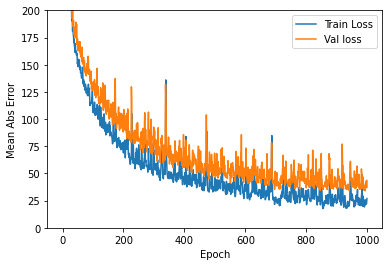

In [14]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

plot_history(history)

# Evaluation

In [15]:
X_test.shape

(684, 5)

In [16]:
y_test.shape

(684, 1)

In [17]:
[loss, mae] = model.evaluate(X_test, y_test, verbose=0)

In [18]:
print(mae)

41.439743


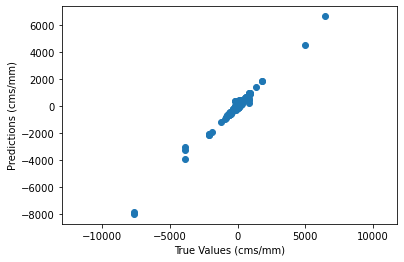

In [19]:
test_predictions = model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values (cms/mm)')
plt.ylabel('Predictions (cms/mm)')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])
plt.savefig('C:/Users/Sam/Documents/ML4EnvEng/NNAug.png')